In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10

# adjust the parameters for displayed figures
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})

In [ ]:
xdat = pd.read_csv('/content/sales_train_validation.csv')
xdat = xdat.loc[xdat.state_id == 'CA']
xdat.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1.0,0.0,5.0,4.0,1.0,0.0,1.0,3.0,7.0,2.0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,4.0


In [ ]:
# melt the data into long format
xdat = pd.melt(xdat, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales').dropna()

# get proper timestamps
xcal = pd.read_csv('/content/calendar.csv')

In [ ]:
xdat = pd.merge(xdat, xcal, on='d', how='left')
del xcal

In [ ]:
xdat.drop(['d', 'wm_yr_wk', 'weekday', 'month', 'year',  'event_name_1', 'event_type_1',
           'event_name_2', 'event_type_2', 'snap_TX', 'snap_WI', 'state_id'],
                  axis = 1, inplace = True)
xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0.0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0.0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0.0,2011-01-29,1,0


<Axes: xlabel='date'>

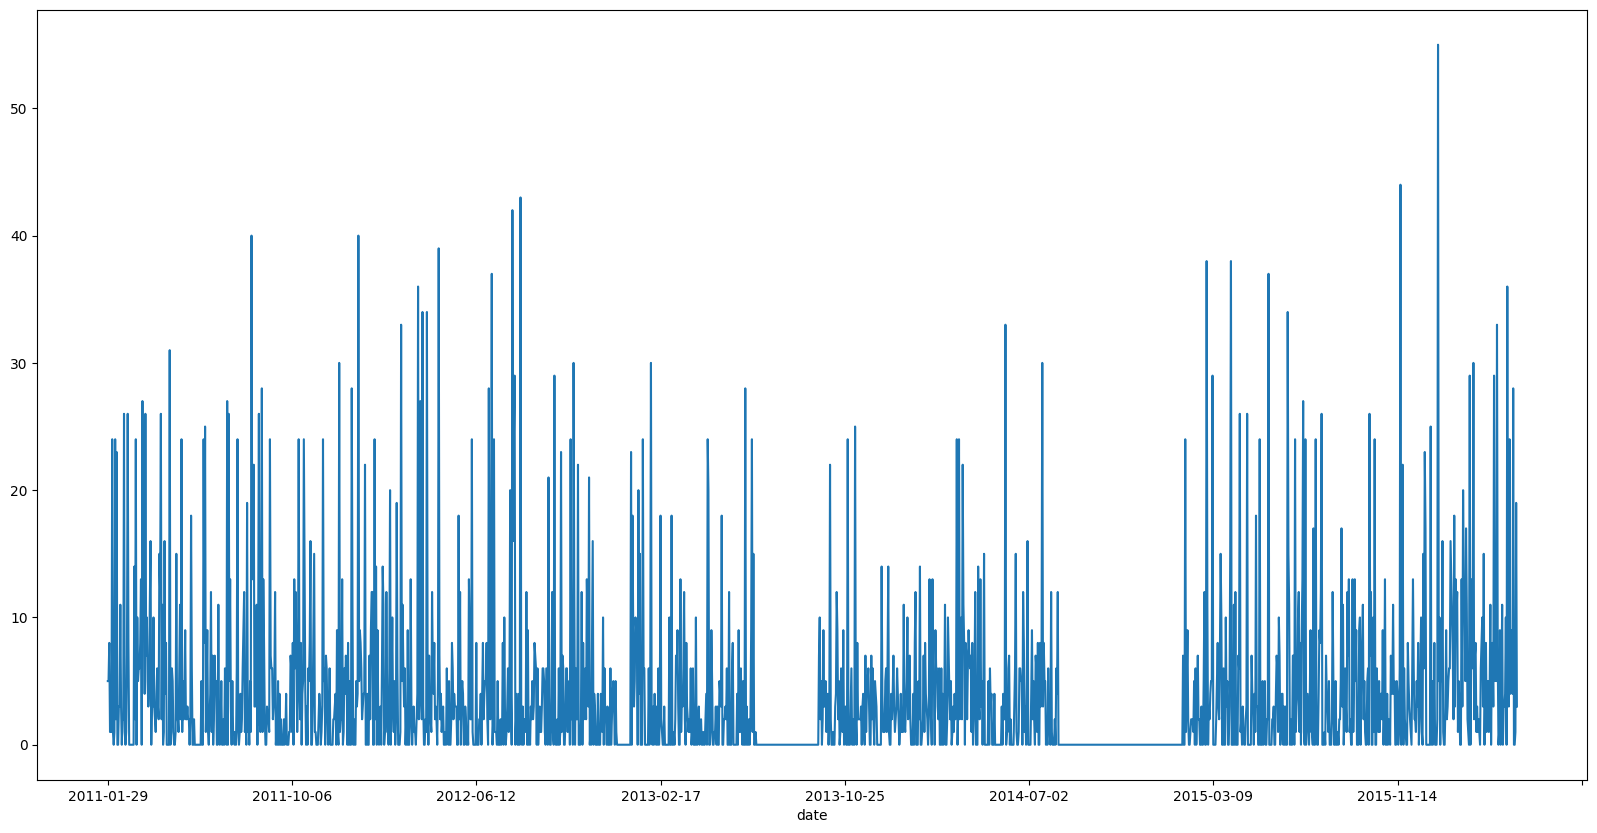

In [ ]:
df = xdat.loc[xdat.item_id == 'HOBBIES_1_288' ][['date', 'sales']].copy()
df.set_index('date').sales.plot()

In [ ]:
def create_features(dt, lags = [28], wins = [7,28]):
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag).fillna(-1)

    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).fillna(-1)

    return dt

xdat = create_features(xdat)

xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA,lag_28,rmean_28_7,rmean_28_28
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0.0,2011-01-29,1,0,-1.0,-1.0,-1.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0.0,2011-01-29,1,0,-1.0,-1.0,-1.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0.0,2011-01-29,1,0,-1.0,-1.0,-1.0


In [ ]:
xdat['date'] = pd.to_datetime(xdat["date"])

date_features = {

        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",

    }

for date_feat_name, date_feat_func in date_features.items():
    if date_feat_name in xdat.columns:
        xdat[date_feat_name] = xdat[date_feat_name].astype("int16")
    else:
        xdat[date_feat_name] = getattr(xdat["date"].dt, date_feat_func).astype("int16")

<ipython-input-42-4d60cf97bcde>:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  xdat[date_feat_name] = getattr(xdat["date"].dt, date_feat_func).astype("int16")


In [ ]:
# encode categorical features
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id']
for cc in cat_feats:
    le = LabelEncoder()
    xdat[cc] = le.fit_transform(xdat[cc])

In [ ]:
# split into train and test
cutoff = xdat.date.max() - pd.to_timedelta(28, unit = 'D')
xtrain = xdat.loc[xdat.date < cutoff].copy()
xvalid = xdat.loc[xdat.date >= cutoff].copy()

del xdat

xtrain.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA,lag_28,rmean_28_7,rmean_28_28,week,month,quarter,year,mday
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0.0,2011-01-29,1,0,-1.0,-1.0,-1.0,4,1,1,2011,29
1,HOBBIES_1_002_CA_1_validation,1,0,0,0,0.0,2011-01-29,1,0,-1.0,-1.0,-1.0,4,1,1,2011,29
2,HOBBIES_1_003_CA_1_validation,2,0,0,0,0.0,2011-01-29,1,0,-1.0,-1.0,-1.0,4,1,1,2011,29


In [ ]:
ytrain = xtrain['sales'].copy()
yvalid = xvalid['sales'].copy()

xtrain.drop(['id', 'wday', 'sales',  'snap_CA', 'year', 'date'], axis = 1, inplace = True)
xvalid.drop(['id', 'wday', 'sales',  'snap_CA', 'year', 'date'], axis = 1, inplace = True)

In [ ]:
import lightgbm as lgb
dtrain = lgb.Dataset(xtrain , label = ytrain,  free_raw_data=False)
dvalid = lgb.Dataset(xvalid, label = yvalid,   free_raw_data=False)

In [ ]:
params = {
        "objective" : "poisson",

        "metric" : "rmse",
        "learning_rate" : 0.075,
         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'verbosity': 1,
       'num_iterations' : 1000,
        'num_leaves': 128,
        "min_data_in_leaf": 50,
}


m_lgb = lgb.train(params, dtrain, valid_sets = [dtrain, dvalid])

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 2007855, number of used features: 10
[LightGBM] [Info] Start training from score -0.080075


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

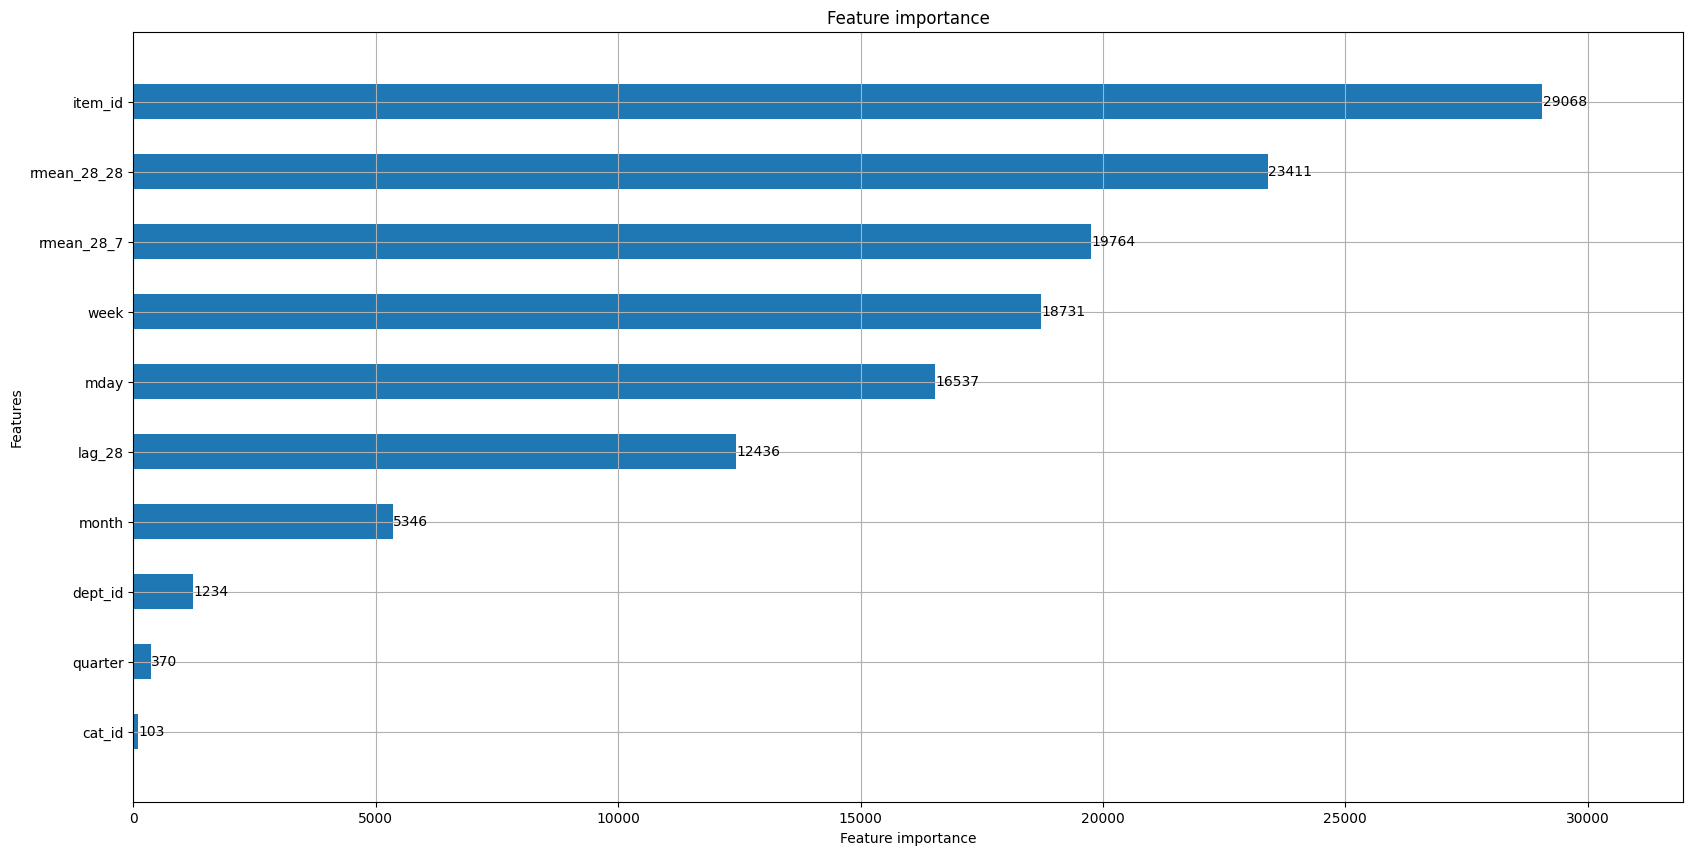

In [ ]:
lgb.plot_importance(m_lgb,height = 0.5)